In [0]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

In [227]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Read in and basic overview

In [262]:
# Read csv dataset
path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
df = pd.read_csv(path_dataset)
#print(df.shape)
df.replace('', np.nan, inplace=True)
# Drop nan values for the following columns
df = df.dropna(subset=['Budget Forecast', 'Total Budget Changes',
                       'Forecast Completion', 'Total Schedule Changes'], how='all')
# Only take budget forecast for positive values
df = df[df['Budget Forecast'] > 0]
# Reset index to eliminate completely missing rows from the dataframe
df.reset_index(drop=True, inplace=True)
# Keep only last row of each project
df = df.groupby('PID').tail(1)

# Minimize the effect of ZERO schedule change on regression model
new_df = df[df['Total Schedule Changes'] == 0].sample(n=15, random_state=1)
df = df[df['Total Schedule Changes'] != 0]
df = df.append(new_df)

# Minimize the effect of ZERO budget change on regression model
new_df = df[df['Total Budget Changes'] == 0].sample(n=7, random_state=1)
df = df[df['Total Budget Changes'] != 0]
df = df.append(new_df)
df.describe(include='all')

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,301,301.000000,301,298,301,152,301,240,301,294,3.010000e+02,2.480000e+02,2.480000e+02,299,246.000000,246.000000
unique,4,NaN,301,277,21,19,12,29,5,256,NaN,NaN,NaN,252,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,Bellevue Medical Center Priority Mitigation Pr...,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,05/04/2016,NaN,NaN,NaN,12/31/2019,NaN,NaN
freq,240,NaN,1,16,63,41,152,105,144,7,NaN,NaN,NaN,11,NaN,NaN
mean,NaN,639.368771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.128818e+08,2.684097e+06,2.010676e+07,NaN,66.967480,562.239837
std,NaN,274.070782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.574745e+08,4.023569e+07,8.348361e+07,NaN,216.554972,657.996523
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.116642e+06,-2.664272e+08,-2.919002e+08,NaN,-995.000000,-1412.000000
25%,NaN,474.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.595827e+07,0.000000e+00,0.000000e+00,NaN,0.000000,86.500000
50%,NaN,656.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501760e+07,0.000000e+00,4.953144e+06,NaN,0.000000,450.000000
75%,NaN,868.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.038300e+07,1.000000e+06,2.574161e+07,NaN,91.000000,944.250000


## Regression Model

In [263]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
df.dtypes

Minimum Date: 1993-08-02 00:00:00
Date Reported Minimum: 2018-08-01 00:00:00


Date Reported As Of        datetime64[ns]
PID                                 int64
Project Name                       object
Description                        object
Category                           object
Borough                            object
Managing Agency                    object
Client Agency                      object
Current Phase                      object
Design Start               datetime64[ns]
Budget Forecast                   float64
Latest Budget Changes             float64
Total Budget Changes              float64
Forecast Completion        datetime64[ns]
Latest Schedule Changes           float64
Total Schedule Changes            float64
dtype: object

In [264]:
### (a) Schedule Change Norm ===>  Change Normalized to Project Duration of each project
df['Project Duration'] = df['Forecast Completion'] - df['Design Start']
df['Schedule Change Norm'] = df['Total Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1))

### (b) Project Duration Norm ===> Normalized over all projects (to normalize across big and small projects)
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
df['Project Duration Norm'] = (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration)
df['Project Duration'] = df['Project Duration']/pd.Timedelta(days=1)
print(f'Max Project Duration: {max_project_duration} \n Min Project Duration: {min_project_duration} ')
df.describe(include='all')

Max Project Duration: 9736 days 00:00:00 
 Min Project Duration: 656 days 00:00:00 


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Project Duration,Schedule Change Norm,Project Duration Norm
count,301,301.000000,301,298,301,152,301,240,301,294,3.010000e+02,2.480000e+02,2.480000e+02,299,246.000000,246.000000,293.000000,241.000000,293.000000
unique,4,NaN,301,277,21,19,12,29,5,256,NaN,NaN,NaN,252,NaN,NaN,NaN,NaN,NaN
top,2019-09-01 00:00:00,NaN,Bellevue Medical Center Priority Mitigation Pr...,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,2016-05-04 00:00:00,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,240,NaN,1,16,63,41,152,105,144,7,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN
first,2018-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993-08-02 00:00:00,NaN,NaN,NaN,2019-03-29 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2019-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-30 00:00:00,NaN,NaN,NaN,2031-07-07 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,639.368771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.128818e+08,2.684097e+06,2.010676e+07,NaN,66.967480,562.239837,2773.535836,0.180054,0.233209
std,NaN,274.070782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.574745e+08,4.023569e+07,8.348361e+07,NaN,216.554972,657.996523,1418.030371,0.218157,0.156171
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.116642e+06,-2.664272e+08,-2.919002e+08,NaN,-995.000000,-1412.000000,656.000000,-0.722620,0.000000
25%,NaN,474.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.595827e+07,0.000000e+00,0.000000e+00,NaN,0.000000,86.500000,1879.000000,0.037037,0.134692


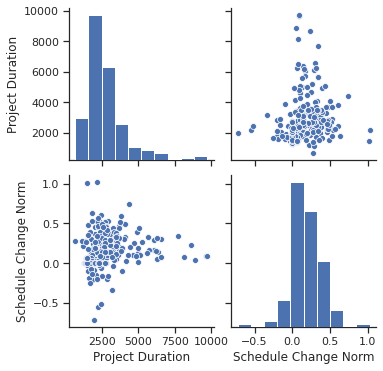

In [241]:
#df['Project Duration Norm'].plot.hist(bins=30, alpha=0.4)
#plt.show()
#df['Schedule Change Norm'].plot.hist(bins=100, alpha=0.4)
#plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Project Duration', 'Schedule Change Norm']])

In [265]:
### (a) Budget Change Norm ===>  Budget Change Normalized to Final Budget of each project
df['Budget Change Norm'] = df['Total Budget Changes']/df['Budget Forecast']

### (b) Total Budget Norm ===> Budget Forecast Normalized through all projects
max_budget_final = max(df['Budget Forecast'])
min_budget_final = min(df['Budget Forecast'])
df['Total Budget Norm'] = (0.9 - 0.1)*(df['Budget Forecast'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')

# Remove outliers
df = df[df['Budget Change Norm'] > -2]
df = df[df['Total Budget Norm'] < 0.3]
min_budget_norm = min(df['Budget Change Norm'])
print(f'Minimum Budget Change Norm: {min_budget_norm}')
df.describe(include='all')

Max Budget: 2449621616.0 
 Min Budget: 2116642.0
Minimum Budget Change Norm: -1.9474624118003965


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Project Duration,Schedule Change Norm,Project Duration Norm,Budget Change Norm,Total Budget Norm
count,235,235.000000,235,235,235,143,235,180,235,230,2.350000e+02,2.350000e+02,2.350000e+02,234,233.000000,233.000000,230.000000,230.000000,230.000000,235.000000,235.000000
unique,4,NaN,235,222,19,18,11,28,5,210,NaN,NaN,NaN,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-09-01 00:00:00,NaN,Bellevue Medical Center Priority Mitigation Pr...,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,2017-05-30 00:00:00,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,180,NaN,1,12,44,39,112,83,120,4,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2018-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993-08-02 00:00:00,NaN,NaN,NaN,2019-06-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-20 00:00:00,NaN,NaN,NaN,2027-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,564.587234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.243385e+07,1.707614e+06,1.511469e+07,NaN,65.296137,548.008584,2872.856522,0.177726,0.244147,0.137055,0.126253
std,NaN,247.255975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.753500e+07,1.141958e+07,3.633377e+07,NaN,201.971731,652.755023,1440.048335,0.218598,0.158596,0.365015,0.025343
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.008834e+07,-6.467696e+07,-1.743460e+08,NaN,-995.000000,-1412.000000,656.000000,-0.722620,0.000000,-1.947462,0.102606
25%,NaN,431.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.933650e+07,0.000000e+00,0.000000e+00,NaN,0.000000,77.000000,1981.250000,0.033659,0.145953,0.000000,0.112166


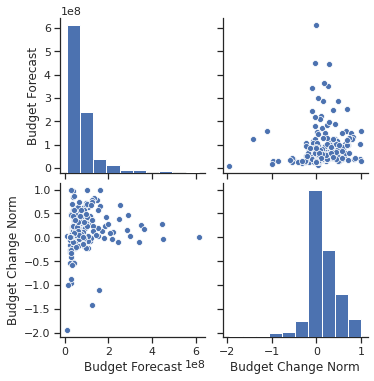

In [268]:
#df[['Schedule Change Norm', 'Project Duration Norm']].plot.hist(bins=12, alpha=0.4)
#df['Total Budget Norm'].plot.hist(bins=30, alpha=0.4)
#plt.show()
#df['Budget Change Norm'].plot.hist(bins=20, alpha=0.4)
#plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Budget Forecast', 'Budget Change Norm']])

In [388]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Total Budget Norm', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Project Duration Norm', 'Current Phase']
nyc_df = nyc_df.drop(drop_columns, axis=1)
# Log of both Project Duration and Budget Forecast
nyc_df['Budget Forecast'] = np.log(nyc_df['Budget Forecast'])
nyc_df['Project Duration'] = np.log(nyc_df['Project Duration'])

nyc_df.describe(include='all')

,Budget Forecast,Project Duration,Schedule Change Norm,Budget Change Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
count,235.000000,230.000000,230.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,17.963800,7.867122,0.177726,0.137055,0.080851,0.059574,0.017021,0.017021,0.004255,0.008511,0.114894,0.004255,0.008511,0.042553,0.012766,0.046809,0.017021,0.051064,0.127660,0.187234,0.093617,0.093617,0.004255,0.165957,0.004255,0.004255,0.029787,0.085106,0.008511,0.004255,0.004255,0.004255,0.004255,0.004255,0.004255,0.127660,0.046809,0.008511,0.004255
std,0.679063,0.421443,0.218598,0.365015,0.273188,0.237202,0.129627,0.129627,0.065233,0.092056,0.319574,0.065233,0.092056,0.202278,0.112503,0.211679,0.129627,0.220598,0.334423,0.390932,0.291917,0.291917,0.065233,0.372837,0.065233,0.065233,0.170363,0.279636,0.092056,0.065233,0.065233,0.065233,0.065233,0.065233,0.065233,0.334423,0.211679,0.092056,0.065233
min,16.126891,6.486161,-0.722620,-1.947462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.487651,7.591483,0.033659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.900327,7.818427,0.164496,0.089425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.389448,8.108095,0.307498,0.326867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.235175,9.183586,1.023743,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
nyc_df = nyc_df.dropna()
np.random.seed(49)
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.2, random_state=49)

In [414]:
nyc_train.head()

,Budget Forecast,Project Duration,Schedule Change Norm,Budget Change Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
168,19.481585,8.090709,0.180147,0.474640,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1489,18.087890,8.156797,0.323487,-0.002092,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1543,17.764039,8.059908,0.137757,0.035674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1807,19.025734,7.790696,0.156328,0.245671,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1797,17.759013,7.593374,0.026196,0.458710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


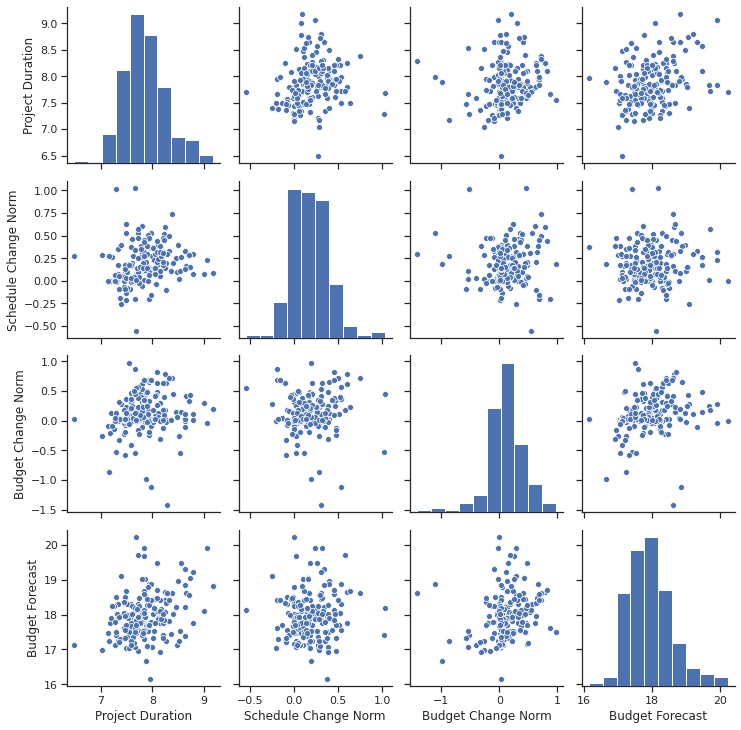

In [423]:
qual_columns = ['Project Duration',	'Schedule Change Norm',
                'Budget Change Norm',	'Budget Forecast']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
plt_df = nyc_train.copy()
sns.set(style="ticks")
sns.pairplot(plt_df[qual_columns])

In [409]:
nyc_train[qual_columns].corr()

,Project Duration,Schedule Change Norm,Budget Change Norm,Budget Forecast
Project Duration,1.000000,0.172431,0.208408,0.342537
Schedule Change Norm,0.172431,1.000000,0.101614,0.054694
Budget Change Norm,0.208408,0.101614,1.000000,0.340040
Budget Forecast,0.342537,0.054694,0.340040,1.000000


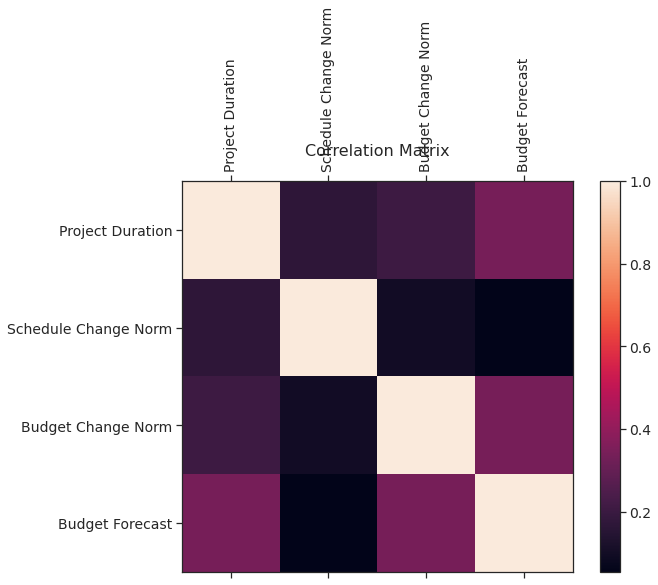

In [410]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [448]:
# Budget change
# 'Project Duration', 'Schedule Change Norm', 'Total Budget Norm', 'Budget Change Norm'
nyc_train_trunc = nyc_train.copy()
nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = (nyc_train_trunc['Budget Change Norm'])
X_train = nyc_train_trunc.drop(['Budget Change Norm'], axis=1)
# Remove redundant columns: found through VIF (multi-collinearity analysis in below cell)

drop_mc_columns = ['Category_Health and Hospitals, IT', 'Category_IT', 'Category_Industrial Development, Parks',
                   'Category_Industrial Development, Streets and Roadways', 'Category_Libraries', 
                   'Borough_Brooklyn, Queens','Borough_Manhattan, Staten Island, Bronx', 'Borough_Olive',
                   'Borough_Marlboro', 'Borough_Port Jervis', 'Category_Streets and Roadways']
X_train = X_train.drop(drop_mc_columns, axis=1, errors='ignore')

# No need for polynomial interactions - doesn't improve score
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#X_train = poly.fit_transform(X_train)

# No need for increasing polynomial terms - decreases the test scores
#X_train['Budget_2T'] = X_train['Budget Forecast'] * X_train['Budget Forecast']
#X_train['Budget_3T'] = X_train['Schedule Change Norm'] * X_train['Budget Forecast']
#X_train['Project_2T'] = X_train['Project Duration'] * X_train['Project Duration']

lr_cost_model = LinearRegression().fit(X_train, y_train)
lr_cost_model.score(X_train, y_train)
alphas = (0.1, 0.5,1,5,10,50,100)
ridge_cost_model = RidgeCV(alphas=alphas,normalize=True, cv=10).fit(X_train, y_train)
lasso_cost_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)

print(f'LinearRegression score: {lr_cost_model.score(X_train, y_train)}')
print(f'Lasso score: {lasso_cost_model.score(X_train, y_train)}')
print(f'Ridge score: {ridge_cost_model.score(X_train, y_train)}')

LinearRegression score: 0.058370124005135526
Lasso score: 0.0
Ridge score: 0.05310148719005903


In [449]:
nyc_test_trunc = nyc_test.copy()
nyc_test_trunc = nyc_test_trunc[qual_columns]
y_test = nyc_test_trunc['Budget Change Norm']
X_test = nyc_test_trunc.drop(['Budget Change Norm'], axis=1)
X_test = X_test.drop(drop_mc_columns, axis=1, errors='ignore')
ridge_cost_model.score(X_test, y_test)

0.05678238395813173

In [450]:
# BAGGING TECHNIQUES
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
num_bags = 10
np.random.seed(49)
bagging_train = np.zeros((X_train.shape[0], num_bags))
bagging_test = np.zeros((X_test.shape[0], num_bags))
bagging_models = []
for i in range(num_bags):
  bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
  fitted_model = RidgeCV(alphas=alphas,normalize=True, cv=5).fit(bootstrapped_X, bootstrapped_y)
  bagging_models.append(fitted_model)
  bagging_train[:,i] = fitted_model.predict(X_train)
  bagging_test[:,i] = fitted_model.predict(X_test)

bagging_train_predicts = np.mean(bagging_train[:,:], axis=1)
bagging_test_predicts = np.mean(bagging_test[:,:], axis=1)
print(f'Training score: {mean_squared_error(y_train, bagging_train_predicts)}')
print(f'Test score: {mean_squared_error(y_test, bagging_test_predicts)}')

Training score: 0.09797945426416234
Test score: 0.18115806583181773


In [451]:
X_train_ols = sm.add_constant(X_train)
results = OLS(y_train, X_train_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.719
Date:                Thu, 07 May 2020   Prob (F-statistic):             0.0125
Time:                        21:30:35   Log-Likelihood:                -46.854
No. Observations:                 184   AIC:                             101.7
Df Residuals:                     180   BIC:                             114.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.1459      0.690     -3.111      0.002      -3.507      -0.785
Project Duration         0.0434      0.061      0.716      0.475      -0.076       0.163
Schedule Change Norm     0.0053      0.112      0.048      0.962      -0.216       0.226
Budget Forecast          0.1070      0.038      2.824      0.005       0.032       0.182
==============================================================================
Omnibus:                       56.802   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.136
Skew:                          -1.075   Prob(JB):                     7.26e-58
Kurtosis:                       8.450   Cond. No.                         583.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [452]:
# Multi-collinearity
X_train_save = X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

Project Duration        365.222640
Schedule Change Norm      1.823515
Budget Forecast         360.094068
dtype: float64

In [328]:
# Remove multi-collinearity
# Transforms
X_train = X_train_save.copy()
drop_mc_columns = ['Category_Health and Hospitals, IT', 'Category_IT', 'Category_Industrial Development, Parks',
                   'Category_Industrial Development, Streets and Roadways', 'Borough_Manhattan, Staten Island, Bronx',
                   'Borough_Marlboro', 'Borough_Port Jervis']
X_train = X_train.drop(drop_mc_columns, axis=1, errors='ignore')
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     9.445
Date:                Thu, 07 May 2020   Prob (F-statistic):           7.91e-06
Time:                        20:14:39   Log-Likelihood:                -48.685
No. Observations:                 184   AIC:                             105.4
Df Residuals:                     180   BIC:                             118.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.1819      0.658     -4.837      0.000      -4.480      -1.884
Project Duration         0.0452      0.058      0.774      0.440      -0.070       0.161
Schedule Change Norm     0.0918      0.112      0.822      0.412      -0.129       0.312
Budget Forecast          0.1646      0.036      4.590      0.000       0.094       0.235
==============================================================================
Omnibus:                       45.721   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.908
Skew:                          -0.801   Prob(JB):                     1.45e-49
Kurtosis:                       8.174   Cond. No.                         551.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

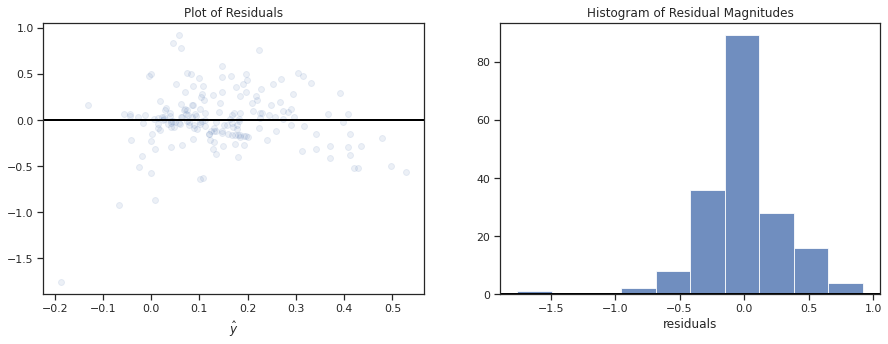

In [329]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


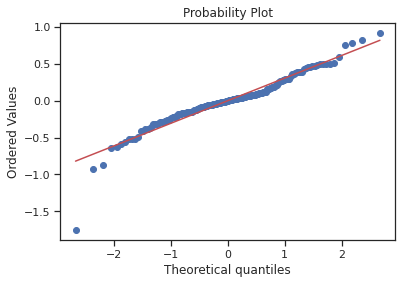

In [330]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

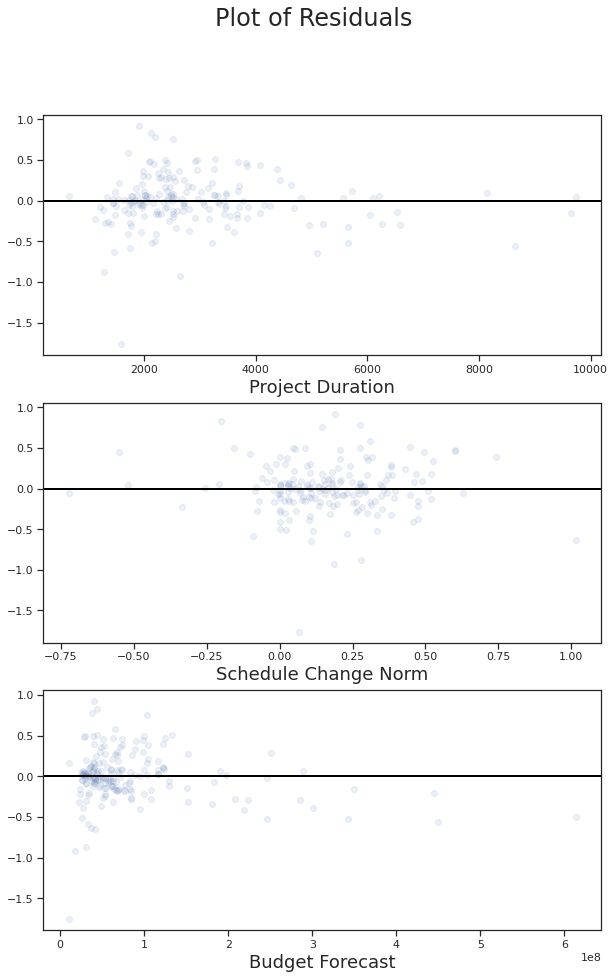

In [332]:
# Residual Plots
X_colms = ['Project Duration','Schedule Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

In [337]:
# Schedule change
y_train = (nyc_train_trunc['Schedule Change Norm'])
X_train = nyc_train_trunc.drop(['Schedule Change Norm'], axis=1)
X_train['Budget Forecast'] = np.log(X_train['Budget Forecast'])
X_train['Project Duration'] = np.log(X_train['Project Duration'])
X_train = X_train.drop(drop_mc_columns, axis=1, errors='ignore')
time_model = LinearRegression().fit(X_train, y_train)
time_model.score(X_train, y_train)

0.02766275387399908

In [338]:
y_test = nyc_test_trunc['Schedule Change Norm']
X_test = nyc_test_trunc.drop(['Schedule Change Norm'], axis=1)
X_test = X_test.drop(drop_mc_columns, axis=1, errors='ignore')
X_test['Budget Forecast'] = np.log(X_test['Budget Forecast'])
X_test['Project Duration'] = np.log(X_test['Project Duration'])
#X_test['Budget_2T'] = X_test['Budget Forecast'] * X_test['Budget Forecast']
#X_test['Project_2T'] = X_test['Project Duration'] * X_test['Project Duration']
time_model.score(X_test, y_test)

0.008662823725909874

In [339]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Schedule Change Norm   R-squared:                       0.028
Model:                              OLS   Adj. R-squared:                  0.011
Method:                   Least Squares   F-statistic:                     1.707
Date:                  Thu, 07 May 2020   Prob (F-statistic):              0.167
Time:                          20:19:17   Log-Likelihood:                 26.169
No. Observations:                   184   AIC:                            -44.34
Df Residuals:                       180   BIC:                            -31.48
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3433      0.465     -0.738      0.461      -1.261       0.574
Project Duration       0.0729      0.039      1.889      0.061      -0.003       0.149
Budget Change Norm     0.0407      0.050      0.822      0.412      -0.057       0.138
Budget Forecast       -0.0038      0.025     -0.150      0.881      -0.054       0.046
==============================================================================
Omnibus:                       20.440   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.779
Skew:                          -0.089   Prob(JB):                     8.69e-20
Kurtosis:                       6.379   Cond. No.                         585.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

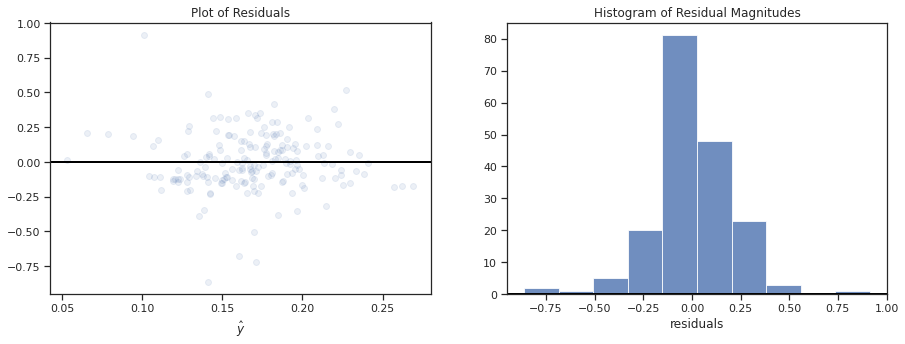

In [340]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

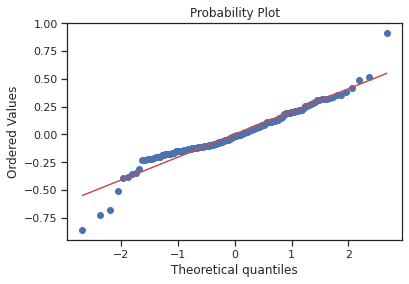

In [341]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

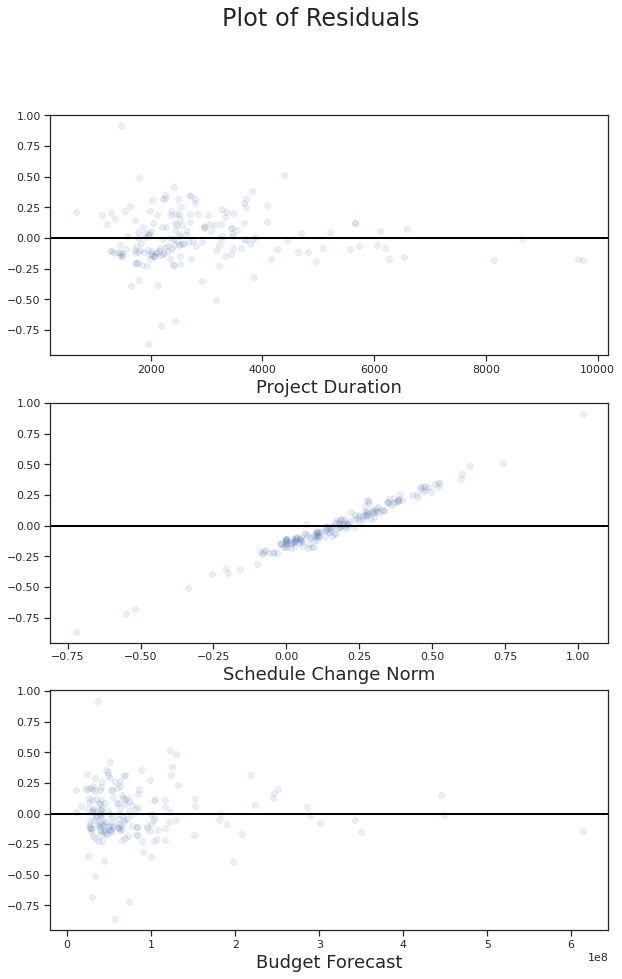

In [343]:
# Residual Plots
X_colms = ['Project Duration','Schedule Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

#### GAM Model

In [470]:
!pip install pygam
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

In [471]:
smoothings = np.logspace(-3, 6, 9)
cv = 10
from sklearn.model_selection import KFold

kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))

print(smoothings,'\n')
print(scores.shape, '\n')


[1.00000000e-03 1.33352143e-02 1.77827941e-01 2.37137371e+00
 3.16227766e+01 4.21696503e+02 5.62341325e+03 7.49894209e+04
 1.00000000e+06] 

(10, 9) 



In [0]:
y_train = pd.DataFrame(nyc_train['Budget Change Norm'])
X_train = nyc_train[qual_columns].drop('Budget Change Norm', axis=1)

In [473]:
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    train_df = X_train.iloc[train_index,:]
    test_df = X_train.iloc[test_index,:]
    train_y = y_train.iloc[train_index,:]
    test_y = y_train.iloc[test_index,:]
    
    for j, smoothing in enumerate(smoothings):
        cur_model = LinearGAM(s(0) + s(1) + s(2), lam = smoothing).fit(train_df, train_y)
        scores[i,j] = r2_score(test_y, cur_model.predict(test_df))
                              
best_lambda = smoothings[np.argmax(np.mean(scores, axis = 0))]
best_lambda

421.6965034285823

In [474]:
nyc_gam1 = LinearGAM(s(0) + s(1) + s(2), lam=best_lambda).fit(X_train, y_train)
r_score_train = r2_score(y_train, nyc_gam1.predict(X_train))

X_test = nyc_test[qual_columns].drop('Budget Change Norm', axis=1)
y_test = nyc_test['Budget Change Norm']
r_score_test = r2_score(y_test, nyc_gam1.predict(X_test))


print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(nyc_gam1.summary())


###########################################################

Lambda = 421.697
Training R-Squared = 0.14320
Testing R-Squared = 0.15883

###########################################################

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.5538
Link Function:                     IdentityLink Log Likelihood:                                  -695.0519
Number of Samples:                          184 AIC:                                             1405.2113
                                                AICc:                                            1405.9479
                                                GCV:                                                0.0982
                                                Scale

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  
